In [1]:
import numpy as np
import pandas as pd

def Ackley(x1, x2):
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1**2 + x2**2)))
    term2 = -np.exp(0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2)))
    return term1 + term2 + np.e + 20

def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    z = Ackley(x1, x2)
    return x1, x2, z

def create_dataframe(grid):
   x1, x2, z = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Power")

/tmp/ipykernel_590754/3623673326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


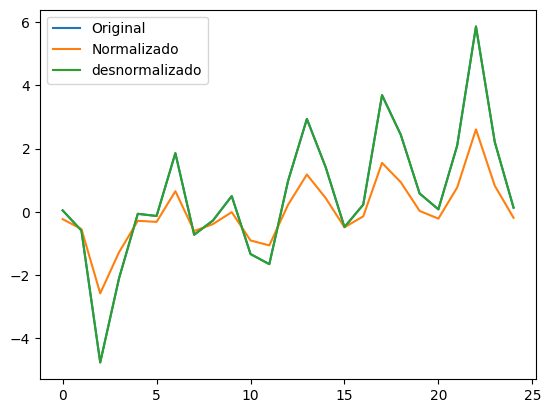

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects:   1% (1/53)
remote: Counting objects:   3% (2/53)
remote: Counting objects:   5% (3/53)
remote: Counting objects:   7% (4/53)
remote: Counting objects:   9% (5/53)
remote: Counting objects:  11% (6/53)
remote: Counting objects:  13% (7/53)
remote: Counting objects:  15% (8/53)
remote: Counting objects:  16% (9/53)
remote: Counting objects:  18% (10/53)
remote: Counting objects:  20% (11/53)
remote: Counting objects:  22% (12/53)
remote: Counting objects:  24% (13/53)
remote: Counting objects:  26% (14/53)
remote: Counting objects:  28% (15/53)
remote: Counting objects:  30% (16/53)
remote: Counting objects:  32% (17/53)
remote: Counting objects:  33% (18/53)
remote: Counting objects:  35% (19/53)
remote: Counting objects:  37% (20/53)
remote: Counting objects:  39% (21/53)
remote: Counting objects:  41% (22/53)
remote: Counting objects:  43% (23/53)
remote: Counting objects:  45% (24/53)
remote: Counting objects:  47% (25

Resolving deltas:  58% (18/31)
Resolving deltas:  61% (19/31)
Resolving deltas:  64% (20/31)
Resolving deltas:  67% (21/31)
Resolving deltas:  70% (22/31)
Resolving deltas:  74% (23/31)
Resolving deltas:  77% (24/31)
Resolving deltas:  80% (25/31)
Resolving deltas:  83% (26/31)
Resolving deltas:  87% (27/31)
Resolving deltas:  90% (28/31)
Resolving deltas:  93% (29/31)
Resolving deltas:  96% (30/31)
Resolving deltas: 100% (31/31)
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-09 19:45:20.027191: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 19:45:20.115710: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 19:45:20.115744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 19:45:20.116995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 19:45:20.125947: I tensorflow/core/platform/cpu_feature_guar

2024-09-09 19:45:24.115078: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01


+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  7



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 3s


 6/32 [====>.........................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 11ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 199ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


10/32 [========>.....................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


 9/32 [=======>......................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 9ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



 1/32 [..............................] - ETA: 1s


12/32 [==========>...................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  28

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++

Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 10ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  29

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 1s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 50ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


 7/32 [=====>........................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.903012,0.682140,0.759523,0.945919,0.403716,2.125528,0.860172,0.264512,0.837928,0.635387,7.207251,0.645394,131.814085,273.149258
model_1_5_8,0.900995,0.680070,0.757428,0.944577,0.412110,2.139376,0.867666,0.271077,0.845918,0.641958,7.336309,0.652068,131.772929,273.108101
model_1_5_7,0.898942,0.677981,0.755287,0.943199,0.420655,2.153340,0.875323,0.277819,0.853796,0.648579,7.467688,0.658794,131.731884,273.067057
model_1_5_6,0.896835,0.675850,0.753051,0.941770,0.429429,2.167596,0.883322,0.284807,0.861934,0.655308,7.602587,0.665629,131.690598,273.025771
model_1_5_5,0.894673,0.673676,0.750752,0.940283,0.438426,2.182127,0.891547,0.292081,0.870195,0.662138,7.740924,0.672566,131.649128,272.984300
model_1_5_4,0.892474,0.671480,0.748408,0.938737,0.447578,2.196817,0.899929,0.299638,0.878413,0.669013,7.881635,0.679549,131.607809,272.942981
model_1_5_3,0.890199,0.669240,0.745981,0.937081,0.457051,2.211795,0.908611,0.307743,0.886785,0.676055,8.027282,0.686702,131.565922,272.901094
model_1_5_2,0.887899,0.666991,0.743526,0.935403,0.466623,2.226833,0.917392,0.315949,0.895039,0.683098,8.174463,0.693856,131.524466,272.859638
model_1_5_1,0.885541,0.664721,0.740937,0.933636,0.476437,2.242012,0.926654,0.324589,0.903473,0.690244,8.325344,0.701115,131.482841,272.818014
model_1_5_0,0.880648,0.660029,0.735544,0.929947,0.496805,2.273387,0.945944,0.342635,0.920770,0.704844,8.638517,0.715945,131.399115,272.734287


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  23

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 11ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.926251,0.717731,0.774966,0.795878,0.306984,1.887533,0.804933,0.611823,0.991842,0.554062,5.719966,0.562787,132.361918,273.697091
model_1_6_8,0.926350,0.717134,0.774604,0.802766,0.306571,1.891528,0.806228,0.591177,0.979263,0.553688,5.713609,0.562408,132.364614,273.699787
model_1_6_7,0.926752,0.716453,0.774141,0.811932,0.304896,1.896082,0.807886,0.563704,0.959630,0.552174,5.687866,0.560870,132.375567,273.710739
model_1_6_6,0.927008,0.716089,0.774358,0.820595,0.303831,1.898513,0.807107,0.537736,0.951415,0.551209,5.671487,0.559890,132.382567,273.717739
model_1_6_5,0.926530,0.715387,0.773976,0.823947,0.305822,1.903210,0.808476,0.527688,0.948429,0.553012,5.702102,0.561721,132.369502,273.704675
model_1_6_4,0.926479,0.714784,0.773831,0.830328,0.306033,1.907239,0.808993,0.508562,0.933956,0.553203,5.705348,0.561915,132.368122,273.703295
model_1_6_3,0.926668,0.714172,0.773652,0.838501,0.305246,1.911334,0.809635,0.484066,0.918409,0.552490,5.693235,0.561191,132.373277,273.708450
model_1_6_2,0.926357,0.713548,0.773400,0.843407,0.306541,1.915503,0.810535,0.469361,0.910457,0.553662,5.713157,0.562381,132.364806,273.699978
model_1_6_1,0.926902,0.712854,0.773629,0.861856,0.304271,1.920148,0.809718,0.414063,0.881609,0.551608,5.678253,0.560295,132.379672,273.714845
model_1_6_0,0.926952,0.712340,0.773470,0.869629,0.304065,1.923584,0.810285,0.390764,0.865435,0.551421,5.675084,0.560105,132.381027,273.716200


DataFrame salvo em ../results/metrics_1_6


+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  40

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



 1/32 [..............................] - ETA: 1s


13/32 [===========>..................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.950289,0.752045,0.811609,0.864951,0.206924,1.658078,0.673864,0.685104,0.688535,0.454889,4.181514,0.462053,133.150807,274.485980
model_1_7_8,0.950162,0.751612,0.811784,0.865825,0.207453,1.660969,0.673239,0.680668,0.693731,0.455471,4.189655,0.462644,133.145696,274.480869
model_1_7_7,0.950666,0.751371,0.812164,0.869406,0.205355,1.662582,0.671877,0.662501,0.698190,0.453161,4.157386,0.460298,133.166032,274.501205
model_1_7_6,0.950736,0.750991,0.812317,0.871143,0.205062,1.665128,0.671329,0.653692,0.702860,0.452838,4.152890,0.459970,133.168883,274.504055
model_1_7_5,0.950566,0.750532,0.812274,0.871929,0.205769,1.668192,0.671484,0.649707,0.708322,0.453618,4.163754,0.460762,133.162003,274.497176
model_1_7_4,0.950757,0.750222,0.812391,0.874242,0.204974,1.670264,0.671067,0.637970,0.712586,0.452741,4.151537,0.459871,133.169741,274.504914
model_1_7_3,0.950524,0.749761,0.812381,0.874808,0.205943,1.673351,0.671103,0.635099,0.718016,0.453810,4.166433,0.460957,133.160310,274.495482
model_1_7_2,0.950352,0.749378,0.812281,0.875732,0.206662,1.675912,0.671460,0.630411,0.723684,0.454601,4.177489,0.461761,133.153339,274.488512
model_1_7_1,0.950195,0.748950,0.812132,0.876697,0.207313,1.678776,0.671993,0.625518,0.729165,0.455317,4.187499,0.462487,133.147048,274.482221
model_1_7_0,0.950210,0.748577,0.812026,0.878394,0.207252,1.681269,0.672372,0.616908,0.734201,0.455249,4.186555,0.462419,133.147641,274.482814


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  25

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 48ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 61ms/step



 1/32 [..............................] - ETA: 2s


 7/32 [=====>........................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 8ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 132ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 78ms/step



 1/32 [..............................] - ETA: 2s


 7/32 [=====>........................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 9ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 76ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 60ms/step



 1/32 [..............................] - ETA: 1s


10/32 [========>.....................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 7ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 73ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.971588,0.766151,0.803985,0.980076,0.118264,1.563747,0.701133,0.100525,0.567487,0.343895,2.818336,0.349311,134.269678,275.604850
model_1_8_8,0.971068,0.765777,0.804394,0.979904,0.120431,1.566251,0.699673,0.101390,0.571245,0.347032,2.851666,0.352498,134.233350,275.568522
model_1_8_7,0.970527,0.765350,0.804478,0.979688,0.122682,1.569108,0.699372,0.102483,0.574822,0.350260,2.886275,0.355777,134.196314,275.531486
model_1_8_6,0.969973,0.764915,0.804652,0.979456,0.124986,1.572016,0.698748,0.103653,0.578511,0.353534,2.921697,0.359102,134.159104,275.494277
model_1_8_5,0.969399,0.764396,0.804394,0.979136,0.127379,1.575483,0.699672,0.105269,0.581991,0.356901,2.958480,0.362522,134.121185,275.456357
model_1_8_4,0.968818,0.763965,0.804885,0.978892,0.129796,1.578365,0.697914,0.106496,0.586215,0.360273,2.995654,0.365947,134.083578,275.418750
model_1_8_3,0.968225,0.763518,0.805094,0.978632,0.132265,1.581354,0.697167,0.107808,0.590061,0.363683,3.033614,0.369410,134.045893,275.381066
model_1_8_2,0.967621,0.763094,0.805376,0.978388,0.134779,1.584192,0.696159,0.109040,0.594000,0.367122,3.072260,0.372904,134.008242,275.343414
model_1_8_1,0.967001,0.762623,0.805449,0.978089,0.137358,1.587338,0.695897,0.110551,0.597694,0.370619,3.111921,0.376456,133.970326,275.305499
model_1_8_0,0.966360,0.762199,0.806072,0.977817,0.140029,1.590177,0.693670,0.111920,0.602236,0.374205,3.152990,0.380098,133.931807,275.266979


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.973671,0.771152,0.797676,0.970857,0.109596,1.530310,0.723702,0.114974,0.500050,0.331053,2.685068,0.336267,134.421910,275.757082
model_1_9_8,0.973711,0.770836,0.798994,0.973294,0.109430,1.532418,0.718986,0.105357,0.514632,0.330803,2.682524,0.336013,134.424932,275.760104
model_1_9_7,0.973929,0.770795,0.799928,0.976522,0.108522,1.532692,0.715645,0.092621,0.495957,0.329427,2.668557,0.334615,134.441603,275.776776
model_1_9_6,0.973845,0.770375,0.800940,0.978411,0.108870,1.535501,0.712025,0.085169,0.509892,0.329955,2.673913,0.335152,134.435194,275.770366
model_1_9_5,0.973634,0.769957,0.801585,0.979661,0.109749,1.538297,0.709720,0.080238,0.526338,0.331284,2.687421,0.336501,134.419119,275.754292
model_1_9_4,0.973458,0.769500,0.802280,0.981140,0.110481,1.541352,0.707233,0.074407,0.536234,0.332387,2.698676,0.337622,134.405823,275.740995
model_1_9_3,0.972814,0.768323,0.803341,0.982731,0.113161,1.549224,0.703439,0.068128,0.567676,0.336395,2.739887,0.341692,134.357882,275.693054
model_1_9_2,0.972735,0.767907,0.804009,0.984772,0.113491,1.552005,0.701047,0.060077,0.557652,0.336884,2.744958,0.342190,134.352061,275.687234
model_1_9_1,0.972453,0.767391,0.804080,0.985808,0.114667,1.555458,0.700794,0.055988,0.554260,0.338625,2.763035,0.343958,134.331448,275.666620
model_1_9_0,0.972013,0.766806,0.804105,0.986154,0.116498,1.559368,0.700705,0.054625,0.564923,0.341318,2.791188,0.346693,134.299764,275.634936


DataFrame salvo em ../results/metrics_1_9


+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 1s


12/32 [==========>...................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 45ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 1s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.978141,0.770511,0.789248,0.978876,0.090991,1.534592,0.753847,0.058946,0.584470,0.301646,2.399005,0.306397,134.793999,276.129171
model_1_10_8,0.977961,0.770303,0.789763,0.980236,0.091737,1.535982,0.752004,0.055151,0.578701,0.302882,2.410485,0.307652,134.777654,276.112827
model_1_10_7,0.977780,0.770074,0.790348,0.981558,0.092492,1.537518,0.749913,0.051464,0.572266,0.304125,2.422090,0.308915,134.761267,276.096440
model_1_10_6,0.977598,0.769920,0.791348,0.982910,0.093251,1.538543,0.746336,0.047691,0.564667,0.305370,2.433760,0.310180,134.744921,276.080094
model_1_10_5,0.977344,0.769702,0.792020,0.983809,0.094308,1.540003,0.743931,0.045180,0.558653,0.307096,2.450015,0.311933,134.722374,276.057546
model_1_10_0,0.975559,0.769696,0.797398,0.987726,0.101736,1.540042,0.724696,0.034251,0.523041,0.318961,2.564224,0.323985,134.570742,275.905915
model_1_10_4,0.977097,0.769628,0.792854,0.984828,0.095334,1.540501,0.740950,0.042337,0.551896,0.308763,2.465791,0.313625,134.700731,276.035904
model_1_10_1,0.975894,0.769551,0.796708,0.987263,0.100342,1.541011,0.727163,0.035543,0.528009,0.316768,2.542786,0.321757,134.598342,275.933515
model_1_10_2,0.976217,0.769510,0.796136,0.986741,0.098999,1.541285,0.729209,0.036998,0.533221,0.314641,2.522136,0.319596,134.625292,275.960465
model_1_10_3,0.976801,0.769501,0.793869,0.985515,0.096564,1.541351,0.737318,0.040421,0.545944,0.310748,2.484706,0.315642,134.675089,276.010261


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.981524,0.775155,0.792560,0.983637,0.076907,1.503541,0.741999,0.061984,0.560830,0.277322,2.182471,0.281689,135.130310,276.465482
model_1_11_8,0.981217,0.774714,0.792271,0.983673,0.078186,1.506489,0.743033,0.061851,0.562880,0.279618,2.202137,0.284022,135.097320,276.432493
model_1_11_7,0.980904,0.774267,0.791963,0.983713,0.079488,1.509478,0.744135,0.061699,0.565054,0.281936,2.222152,0.286377,135.064294,276.399467
model_1_11_6,0.980586,0.773811,0.791625,0.983764,0.080811,1.512528,0.745346,0.061506,0.567318,0.284272,2.242489,0.288749,135.031289,276.366462
model_1_11_5,0.980260,0.773354,0.791296,0.983803,0.082170,1.515581,0.746521,0.061358,0.569630,0.286654,2.263391,0.291168,134.997923,276.333095
model_1_11_4,0.979926,0.772892,0.790967,0.983838,0.083559,1.518675,0.747698,0.061224,0.572003,0.289067,2.284750,0.293619,134.964393,276.299566
model_1_11_3,0.979585,0.772423,0.790628,0.983873,0.084978,1.521809,0.748912,0.061093,0.574403,0.291510,2.306565,0.296101,134.930719,276.265892
model_1_11_2,0.979236,0.771952,0.790278,0.983904,0.086430,1.524961,0.750164,0.060973,0.576820,0.293990,2.328889,0.298620,134.896835,276.232007
model_1_11_1,0.978879,0.771475,0.789940,0.983929,0.087916,1.528146,0.751374,0.060879,0.579328,0.296506,2.351733,0.301176,134.862747,276.197920
model_1_11_0,0.978514,0.770998,0.789591,0.983950,0.089436,1.531339,0.752621,0.060800,0.581855,0.299058,2.375102,0.303768,134.828466,276.163639


DataFrame salvo em ../results/metrics_1_11


+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


10/32 [========>.....................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 1s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.981865,0.775147,0.792535,0.996119,0.075487,1.503596,0.742089,0.010327,0.555434,0.274749,2.160634,0.279076,135.167589,276.502761
model_1_12_1,0.982197,0.775133,0.792484,0.996002,0.074107,1.503690,0.742271,0.010640,0.550118,0.272225,2.139410,0.276513,135.204501,276.539673
model_1_12_2,0.982522,0.775119,0.792400,0.995886,0.072753,1.503781,0.742572,0.010947,0.544763,0.269727,2.118594,0.273975,135.241377,276.576550
model_1_12_3,0.982840,0.775106,0.792281,0.995772,0.071428,1.503868,0.742998,0.011251,0.539432,0.267261,2.098230,0.271470,135.278122,276.613295
model_1_12_4,0.983153,0.775099,0.792135,0.995660,0.070128,1.503914,0.743520,0.011551,0.534065,0.264816,2.078233,0.268987,135.314875,276.650047
model_1_12_5,0.983459,0.775093,0.791971,0.995549,0.068853,1.503951,0.744108,0.011845,0.528722,0.262398,2.058631,0.266531,135.351569,276.686742
model_1_12_9,0.984624,0.775086,0.791136,0.995138,0.064002,1.504001,0.747095,0.012940,0.508968,0.252987,1.984054,0.256971,135.497670,276.832842
model_1_12_6,0.983758,0.775085,0.791780,0.995438,0.067608,1.504010,0.744792,0.012139,0.523398,0.260015,2.039485,0.264110,135.388071,276.723243
model_1_12_7,0.984052,0.775081,0.791576,0.995332,0.066385,1.504037,0.745522,0.012423,0.518098,0.257652,2.020683,0.261710,135.424577,276.759750
model_1_12_8,0.984340,0.775076,0.791359,0.995228,0.065187,1.504067,0.746297,0.012699,0.512829,0.255316,2.002261,0.259337,135.461006,276.796178


DataFrame salvo em ../results/metrics_1_12


+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 44ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.984955,0.774956,0.791669,0.988333,0.062626,1.504873,0.745187,0.061262,0.504218,0.250253,1.962898,0.254194,135.541138,276.876310
model_1_13_1,0.985255,0.774816,0.792108,0.988565,0.061375,1.505808,0.743616,0.060042,0.501661,0.247739,1.943655,0.251641,135.581511,276.916684
model_1_13_2,0.985527,0.774667,0.792435,0.988698,0.060245,1.506800,0.742446,0.059348,0.498980,0.245448,1.926276,0.249313,135.618688,276.953860
model_1_13_3,0.985781,0.774527,0.792780,0.988778,0.059188,1.507736,0.741215,0.058926,0.496423,0.243286,1.910035,0.247118,135.654065,276.989238
model_1_13_4,0.986004,0.774355,0.793006,0.988761,0.058257,1.508890,0.740406,0.059014,0.494073,0.241365,1.895715,0.245166,135.685788,277.020960
model_1_13_5,0.986210,0.774230,0.793231,0.988695,0.057400,1.509722,0.739599,0.059362,0.491419,0.239582,1.882537,0.243356,135.715431,277.050604
model_1_13_6,0.986401,0.774093,0.793467,0.988581,0.056608,1.510642,0.738757,0.059958,0.488895,0.237924,1.870359,0.241671,135.743220,277.078393
model_1_13_7,0.986563,0.773950,0.793593,0.988377,0.055931,1.511600,0.738308,0.061033,0.486281,0.236497,1.859955,0.240222,135.767273,277.102446
model_1_13_8,0.986704,0.773832,0.793601,0.988104,0.055345,1.512385,0.738279,0.062465,0.483600,0.235256,1.850951,0.238961,135.788323,277.123495
model_1_13_9,0.986831,0.773695,0.793639,0.987799,0.054815,1.513302,0.738140,0.064066,0.481267,0.234126,1.842793,0.237813,135.807589,277.142762


DataFrame salvo em ../results/metrics_1_13


+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 11ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


10/32 [========>.....................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 1s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_9,0.963884,0.781737,0.718698,0.889078,0.150332,1.459528,1.006202,0.646293,1.564219,0.387727,3.311395,0.393833,133.789819,275.124992
model_1_14_8,0.968029,0.781412,0.728432,0.904249,0.133079,1.461699,0.971381,0.557895,1.473854,0.364800,3.046127,0.370545,134.033624,275.368797
model_1_14_7,0.972405,0.781060,0.739111,0.920254,0.114867,1.464056,0.933186,0.464643,1.366937,0.338920,2.766105,0.344257,134.327969,275.663141
model_1_14_6,0.976043,0.780571,0.748240,0.933630,0.099723,1.467324,0.900532,0.386705,1.264801,0.315790,2.533269,0.320763,134.610718,275.945890
model_1_14_5,0.979281,0.779988,0.756907,0.945590,0.086241,1.471224,0.869528,0.317019,1.164475,0.293669,2.325986,0.298294,134.901209,276.236382
model_1_14_4,0.982605,0.779306,0.766637,0.957864,0.072409,1.475783,0.834727,0.245509,1.045444,0.269089,2.113308,0.273327,135.250850,276.586023
model_1_14_3,0.984855,0.778472,0.774028,0.966306,0.063043,1.481361,0.808290,0.196321,0.938357,0.251083,1.969296,0.255037,135.527891,276.863064
model_1_14_2,0.986371,0.777494,0.780186,0.972143,0.056732,1.487900,0.786263,0.162310,0.828138,0.238184,1.872267,0.241936,135.738840,277.074013
model_1_14_1,0.987176,0.776415,0.785327,0.975442,0.053382,1.495115,0.767871,0.143087,0.719774,0.231045,1.820760,0.234684,135.860570,277.195743
model_1_14_0,0.987250,0.775117,0.789725,0.976147,0.053072,1.503793,0.752141,0.138978,0.603180,0.230375,1.816003,0.234003,135.872195,277.207368


DataFrame salvo em ../results/metrics_1_14


+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 45ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 48ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 46ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_0,0.963635,0.781652,0.720138,0.942663,0.151371,1.460096,1.001050,0.288180,1.571116,0.389064,3.327366,0.395191,133.776048,275.111220
model_1_15_1,0.963242,0.781519,0.721559,0.939164,0.153008,1.460984,0.995968,0.305766,1.579893,0.391162,3.352540,0.397323,133.754530,275.089703
model_1_15_2,0.962832,0.781368,0.722923,0.935648,0.154711,1.461993,0.991089,0.323437,1.587639,0.393333,3.378726,0.399528,133.732391,275.067564
model_1_15_3,0.962322,0.781123,0.724237,0.931741,0.156835,1.463630,0.986390,0.343074,1.596323,0.396023,3.411374,0.402260,133.705128,275.040301
model_1_15_4,0.961785,0.780847,0.725515,0.927762,0.159072,1.465479,0.981817,0.363071,1.603596,0.398838,3.445772,0.405119,133.676800,275.011972
model_1_15_5,0.961180,0.780552,0.726780,0.923534,0.161589,1.467449,0.977293,0.384323,1.612098,0.401981,3.484477,0.408312,133.645397,274.980570
model_1_15_6,0.960209,0.780173,0.728059,0.917827,0.165633,1.469983,0.972717,0.413009,1.626009,0.406980,3.546647,0.413389,133.595966,274.931139
model_1_15_7,0.959520,0.779802,0.729260,0.913342,0.168498,1.472466,0.968420,0.435548,1.632437,0.410485,3.590698,0.416949,133.561667,274.896840
model_1_15_8,0.958576,0.779384,0.730412,0.907838,0.172427,1.475259,0.964301,0.463214,1.642581,0.415244,3.651118,0.421783,133.515558,274.850731
model_1_15_9,0.957621,0.778919,0.731531,0.902317,0.176403,1.478373,0.960298,0.490963,1.651060,0.420004,3.712249,0.426619,133.469965,274.805138


DataFrame salvo em ../results/metrics_1_15


+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 59ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 73ms/step



 1/32 [..............................] - ETA: 1s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.958373,0.778699,0.733105,0.920456,0.173274,1.479839,0.954666,0.153759,1.636991,0.416262,3.664138,0.422818,133.505761,274.840933
model_1_16_1,0.959067,0.778474,0.734624,0.920207,0.170385,1.481343,0.949236,0.154240,1.623347,0.412777,3.619717,0.419278,133.539389,274.874562
model_1_16_2,0.959681,0.778226,0.736099,0.919180,0.167830,1.483001,0.943957,0.156224,1.610003,0.409671,3.580433,0.416123,133.569607,274.904780
model_1_16_3,0.960222,0.777963,0.737497,0.917605,0.165579,1.484765,0.938957,0.159270,1.596946,0.406914,3.545817,0.413322,133.596619,274.931791
model_1_16_4,0.960671,0.777676,0.738911,0.915149,0.163708,1.486681,0.933900,0.164016,1.584270,0.404608,3.517053,0.410980,133.619344,274.954517
model_1_16_5,0.961039,0.777365,0.740313,0.911954,0.162177,1.488763,0.928884,0.170192,1.571824,0.402712,3.493517,0.409054,133.638133,274.973306
model_1_16_6,0.961313,0.777045,0.741707,0.907836,0.161034,1.490902,0.923897,0.178152,1.559611,0.401290,3.475942,0.407610,133.652280,274.987453
model_1_16_7,0.961475,0.776683,0.743051,0.902729,0.160359,1.493320,0.919092,0.188024,1.548004,0.400449,3.465568,0.406756,133.660677,274.995850
model_1_16_8,0.961535,0.776311,0.744409,0.896667,0.160113,1.495812,0.914235,0.199743,1.536609,0.400142,3.461789,0.406444,133.663745,274.998918
model_1_16_9,0.961501,0.775917,0.745740,0.889738,0.160251,1.498442,0.909475,0.213136,1.525363,0.400314,3.463905,0.406618,133.662027,274.997199


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 62ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 90ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.962230,0.775761,0.746661,0.996173,0.157217,1.499486,0.906178,0.013482,1.511387,0.396506,3.417250,0.402750,133.700261,275.035434
model_1_17_1,0.962948,0.775625,0.747542,0.996050,0.154229,1.500396,0.903028,0.013914,1.497552,0.392721,3.371321,0.398906,133.738627,275.073800
model_1_17_2,0.963580,0.774940,0.748432,0.995693,0.151599,1.504977,0.899844,0.015171,1.485950,0.389357,3.330874,0.395489,133.773035,275.108208
model_1_17_3,0.964261,0.774721,0.749271,0.995481,0.148766,1.506444,0.896842,0.015919,1.472542,0.385702,3.287320,0.391776,133.810760,275.145933
model_1_17_4,0.964923,0.774563,0.750013,0.995305,0.146008,1.507500,0.894190,0.016540,1.459238,0.382110,3.244909,0.388127,133.848191,275.183364
model_1_17_5,0.965568,0.774424,0.750739,0.995117,0.143324,1.508430,0.891594,0.017201,1.446011,0.378582,3.203646,0.384544,133.885295,275.220468
model_1_17_6,0.966195,0.774288,0.751422,0.994900,0.140715,1.509340,0.889149,0.017965,1.432970,0.375120,3.163534,0.381028,133.922036,275.257208
model_1_17_7,0.966811,0.774166,0.752081,0.994690,0.138150,1.510154,0.886791,0.018705,1.419935,0.371685,3.124090,0.377539,133.958835,275.294007
model_1_17_8,0.967419,0.774088,0.752716,0.994504,0.135619,1.510675,0.884522,0.019360,1.406834,0.368265,3.085182,0.374065,133.995809,275.330982
model_1_17_9,0.968011,0.773933,0.753291,0.994269,0.133156,1.511710,0.882465,0.020190,1.393981,0.364906,3.047316,0.370653,134.032463,275.367635


DataFrame salvo em ../results/metrics_1_17


+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_9,0.972265,0.784330,0.742711,0.945986,0.115448,1.442187,0.920309,0.121350,1.276055,0.339776,2.775043,0.345127,134.317873,275.653045
model_1_18_8,0.971963,0.783433,0.743742,0.946942,0.116703,1.448183,0.916621,0.119203,1.286500,0.341619,2.794346,0.346999,134.296240,275.631413
model_1_18_7,0.971644,0.782438,0.744876,0.947770,0.118034,1.454836,0.912563,0.117343,1.296973,0.343560,2.814800,0.348971,134.273571,275.608744
model_1_18_6,0.971425,0.781317,0.746139,0.949504,0.118945,1.462333,0.908046,0.113447,1.305826,0.344884,2.828812,0.350316,134.258188,275.593361
model_1_18_5,0.971123,0.780288,0.747291,0.950641,0.120200,1.469216,0.903927,0.110893,1.316200,0.346698,2.848103,0.352158,134.237203,275.572375
model_1_18_4,0.970747,0.779196,0.748435,0.951239,0.121765,1.476518,0.899832,0.109549,1.328430,0.348948,2.872165,0.354443,134.211331,275.546503
model_1_18_3,0.970425,0.777958,0.749744,0.952473,0.123108,1.484798,0.895152,0.106778,1.340094,0.350868,2.892820,0.356393,134.189386,275.524559
model_1_18_2,0.969926,0.777011,0.750763,0.952326,0.125185,1.491126,0.891505,0.107107,1.353565,0.353815,2.924757,0.359387,134.155922,275.491095
model_1_18_1,0.969394,0.775905,0.751814,0.952010,0.127398,1.498526,0.887746,0.107817,1.366531,0.356929,2.958782,0.362550,134.120876,275.456049
model_1_18_0,0.968722,0.774890,0.752596,0.950541,0.130197,1.505313,0.884951,0.111117,1.380711,0.360828,3.001811,0.366511,134.077417,275.412590


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_0,0.972675,0.784074,0.743847,0.922459,0.113742,1.443901,0.916243,0.244525,1.252515,0.337256,2.748809,0.342567,134.347652,275.682824
model_1_19_1,0.973046,0.783805,0.744946,0.922873,0.112197,1.445698,0.912313,0.243218,1.228979,0.334958,2.725061,0.340234,134.374997,275.710169
model_1_19_2,0.973367,0.783473,0.746070,0.923013,0.110861,1.447915,0.908291,0.242777,1.204849,0.332958,2.704522,0.338202,134.398952,275.734125
model_1_19_3,0.973635,0.783111,0.747170,0.922850,0.109744,1.450335,0.904358,0.243290,1.181318,0.331276,2.687342,0.336493,134.419213,275.754385
model_1_19_4,0.973879,0.782741,0.748216,0.922579,0.108728,1.452812,0.900618,0.244145,1.157663,0.329740,2.671725,0.334933,134.437809,275.772982
model_1_19_5,0.974045,0.782306,0.749296,0.921827,0.108036,1.455718,0.896754,0.246516,1.133627,0.328689,2.661089,0.333865,134.450575,275.785747
model_1_19_6,0.974168,0.781819,0.750387,0.920835,0.107525,1.458978,0.892853,0.249646,1.109315,0.327909,2.653219,0.333074,134.460073,275.795245
model_1_19_7,0.974231,0.781326,0.751404,0.919485,0.107263,1.462276,0.889214,0.253903,1.086144,0.327510,2.649199,0.332668,134.464942,275.800115
model_1_19_8,0.974255,0.780774,0.752431,0.917910,0.107164,1.465962,0.885540,0.258868,1.062132,0.327358,2.647669,0.332514,134.466798,275.801971
model_1_19_9,0.974249,0.780223,0.753393,0.916170,0.107191,1.469653,0.882097,0.264356,1.038296,0.327400,2.648088,0.332556,134.466290,275.801462


DataFrame salvo em ../results/metrics_1_19


+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 84ms/step



 1/32 [..............................] - ETA: 1s


10/32 [========>.....................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 7ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


 9/32 [=======>......................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 8ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_0,0.978579,0.779137,0.767138,0.989021,0.089165,1.476912,0.832935,0.038130,0.950520,0.298605,2.370931,0.303307,134.834541,276.169714
model_1_20_1,0.978949,0.779024,0.768373,0.988877,0.087624,1.477667,0.828516,0.038627,0.942195,0.296014,2.347251,0.300676,134.869389,276.204562
model_1_20_2,0.979307,0.778935,0.769644,0.988726,0.086136,1.478263,0.823971,0.039154,0.934068,0.293489,2.324363,0.298111,134.903659,276.238831
model_1_20_3,0.979654,0.778859,0.770962,0.988546,0.084691,1.478772,0.819257,0.039777,0.925959,0.291017,2.302148,0.295600,134.937491,276.272663
model_1_20_4,0.979988,0.778770,0.772309,0.988333,0.083300,1.479364,0.814438,0.040518,0.917911,0.288618,2.280767,0.293164,134.970604,276.305777
model_1_20_5,0.980315,0.778667,0.773497,0.988116,0.081940,1.480055,0.810189,0.041272,0.909889,0.286252,2.259851,0.290760,135.003535,276.338707
model_1_20_6,0.980631,0.778603,0.774886,0.987864,0.080625,1.480481,0.805219,0.042148,0.902025,0.283946,2.239638,0.288418,135.035882,276.371055
model_1_20_7,0.980929,0.778505,0.776100,0.987560,0.079384,1.481140,0.800879,0.043201,0.894269,0.281751,2.220548,0.286189,135.066922,276.402095
model_1_20_8,0.981213,0.778381,0.777254,0.987228,0.078201,1.481967,0.796750,0.044355,0.886691,0.279645,2.202367,0.284049,135.096937,276.432110
model_1_20_9,0.981495,0.778243,0.778340,0.986914,0.077027,1.482889,0.792866,0.045446,0.879051,0.277538,2.184313,0.281909,135.127196,276.462368


DataFrame salvo em ../results/metrics_1_20


+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 1s


12/32 [==========>...................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_9,0.984708,0.779796,0.783511,0.991573,0.063654,1.472503,0.774370,0.019063,0.795379,0.252298,1.978705,0.256272,135.508572,276.843744
model_1_21_8,0.984439,0.779557,0.783374,0.991782,0.064775,1.474103,0.774857,0.018590,0.802829,0.254508,1.995927,0.258517,135.473685,276.808857
model_1_21_7,0.984163,0.779322,0.783212,0.991979,0.065922,1.475672,0.775437,0.018142,0.810294,0.256752,2.013566,0.260796,135.438571,276.773744
model_1_21_6,0.983880,0.779111,0.783117,0.992153,0.067100,1.477083,0.775777,0.017749,0.817855,0.259037,2.031686,0.263117,135.403134,276.738306
model_1_21_5,0.983595,0.778915,0.782885,0.992353,0.068287,1.478397,0.776609,0.017298,0.825887,0.261319,2.049938,0.265434,135.368060,276.703232
model_1_21_4,0.983315,0.778783,0.782316,0.992592,0.069453,1.479282,0.778645,0.016757,0.834537,0.263540,2.067866,0.267691,135.334196,276.669369
model_1_21_0,0.981879,0.778535,0.778695,0.991852,0.075429,1.480935,0.791596,0.018432,0.869925,0.274644,2.159746,0.278969,135.169120,276.504292
model_1_21_3,0.982997,0.778379,0.781991,0.992603,0.070774,1.481983,0.779805,0.016731,0.844520,0.266033,2.088165,0.270223,135.296536,276.631709
model_1_21_2,0.982674,0.778272,0.781346,0.992667,0.072119,1.482694,0.782111,0.016587,0.853385,0.268550,2.108851,0.272779,135.258872,276.594045
model_1_21_1,0.982338,0.778029,0.781051,0.992672,0.073518,1.484324,0.783167,0.016575,0.862211,0.271143,2.130367,0.275413,135.220437,276.555610


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 2s


 8/32 [======>.......................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 1s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_9,0.986855,0.781247,0.784932,0.983938,0.054718,1.462802,0.769287,0.026425,0.763661,0.233920,1.841311,0.237604,135.811110,277.146282
model_1_22_8,0.986686,0.781156,0.784793,0.984845,0.055418,1.463413,0.769781,0.024931,0.765072,0.235410,1.852068,0.239118,135.785699,277.120871
model_1_22_7,0.986508,0.781054,0.784632,0.985663,0.056161,1.464092,0.770358,0.023587,0.766355,0.236984,1.863498,0.240716,135.759050,277.094222
model_1_22_6,0.986320,0.780946,0.784479,0.986427,0.056945,1.464815,0.770906,0.022329,0.767721,0.238631,1.875538,0.242389,135.731355,277.066528
model_1_22_5,0.986121,0.780826,0.784337,0.987130,0.057772,1.465615,0.771415,0.021173,0.769203,0.240359,1.888265,0.244144,135.702491,277.037664
model_1_22_4,0.985913,0.780688,0.784197,0.987765,0.058638,1.466540,0.771913,0.020128,0.772545,0.242153,1.901580,0.245967,135.672734,277.007907
model_1_22_3,0.985694,0.780536,0.784056,0.988329,0.059548,1.467555,0.772418,0.019201,0.776952,0.244024,1.915562,0.247867,135.641956,276.977128
model_1_22_2,0.985464,0.780379,0.783906,0.988811,0.060506,1.468608,0.772954,0.018407,0.781380,0.245980,1.930300,0.249854,135.610018,276.945190
model_1_22_1,0.985221,0.780203,0.783772,0.989208,0.061517,1.469785,0.773435,0.017755,0.785984,0.248027,1.945849,0.251933,135.576867,276.912040
model_1_22_0,0.984971,0.780011,0.783637,0.989553,0.062560,1.471067,0.773918,0.017187,0.790592,0.250119,1.961872,0.254058,135.543269,276.878441


DataFrame salvo em ../results/metrics_1_22


+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 1s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_9,0.990999,0.784259,0.783886,0.994547,0.037467,1.442658,0.773027,0.033567,0.620461,0.193563,1.576060,0.196611,136.568609,277.903781
model_1_23_8,0.990844,0.784120,0.783945,0.994536,0.038113,1.443590,0.772817,0.033638,0.623883,0.195225,1.585995,0.198300,136.534409,277.869581
model_1_23_7,0.990683,0.783982,0.784007,0.994517,0.038783,1.444513,0.772595,0.033755,0.627508,0.196934,1.596301,0.200036,136.499540,277.834713
model_1_23_6,0.990517,0.783842,0.784074,0.994492,0.039474,1.445448,0.772354,0.033907,0.631251,0.198680,1.606918,0.201809,136.464244,277.799417
model_1_23_5,0.990346,0.783702,0.784136,0.994460,0.040185,1.446387,0.772133,0.034105,0.635168,0.200461,1.617852,0.203619,136.428533,277.763706
model_1_23_4,0.990169,0.783557,0.784197,0.994419,0.040921,1.447354,0.771914,0.034356,0.639286,0.202290,1.629177,0.205476,136.392207,277.727380
model_1_23_3,0.989986,0.783410,0.784262,0.994369,0.041683,1.448340,0.771683,0.034663,0.643621,0.204164,1.640887,0.207379,136.355327,277.690499
model_1_23_2,0.989797,0.783260,0.784328,0.994310,0.042472,1.449343,0.771448,0.035028,0.648433,0.206088,1.653020,0.209333,136.317816,277.652989
model_1_23_1,0.989599,0.783110,0.784389,0.994237,0.043292,1.450346,0.771227,0.035477,0.655988,0.208068,1.665634,0.211345,136.279554,277.614726
model_1_23_0,0.989396,0.782952,0.784452,0.994153,0.044141,1.451404,0.771004,0.035997,0.663860,0.210098,1.678684,0.213407,136.240722,277.575894


DataFrame salvo em ../results/metrics_1_23


+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  34

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_9,0.992227,0.798300,0.763585,0.985584,0.032354,1.348769,0.845643,0.092549,0.411355,0.179871,1.497446,0.182704,136.862059,278.197231
model_1_24_8,0.992402,0.798057,0.764003,0.986363,0.031627,1.350392,0.844146,0.087548,0.417948,0.177839,1.486267,0.180639,136.907518,278.242690
model_1_24_7,0.992498,0.797890,0.764283,0.986893,0.031226,1.351514,0.843147,0.084145,0.421141,0.176709,1.480108,0.179492,136.933011,278.268184
model_1_24_6,0.992577,0.797753,0.764659,0.987374,0.030897,1.352427,0.841800,0.081058,0.424019,0.175777,1.475057,0.178545,136.954161,278.289333
model_1_24_5,0.992660,0.797570,0.765025,0.987872,0.030552,1.353650,0.840492,0.077861,0.427003,0.174792,1.469748,0.177545,136.976641,278.311813
model_1_24_4,0.992773,0.797323,0.765280,0.988478,0.030081,1.355302,0.839579,0.073969,0.430368,0.173440,1.462509,0.176171,137.007699,278.342872
model_1_24_3,0.992837,0.797075,0.765808,0.988922,0.029818,1.356963,0.837693,0.071116,0.434489,0.172678,1.458453,0.175397,137.025315,278.360487
model_1_24_2,0.992922,0.796866,0.766228,0.989440,0.029460,1.358355,0.836190,0.067796,0.436843,0.171640,1.452962,0.174344,137.049414,278.384587
model_1_24_1,0.993005,0.796623,0.766677,0.989947,0.029117,1.359982,0.834583,0.064538,0.438967,0.170637,1.447684,0.173325,137.072856,278.408028
model_1_24_0,0.993103,0.796301,0.767173,0.990515,0.028709,1.362139,0.832808,0.060889,0.441335,0.169436,1.441403,0.172105,137.101117,278.436290


DataFrame salvo em ../results/metrics_1_24


+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_9,0.993308,0.799384,0.753953,0.983493,0.027858,1.341520,0.880095,0.026826,0.230362,0.166906,1.428319,0.169535,137.161297,278.496469
model_1_25_8,0.993367,0.799182,0.755531,0.985841,0.027612,1.342873,0.874450,0.023012,0.228326,0.166167,1.424535,0.168784,137.179045,278.514217
model_1_25_7,0.993415,0.798786,0.757335,0.988085,0.027410,1.345520,0.868000,0.019365,0.250587,0.165559,1.421431,0.168166,137.193721,278.528894
model_1_25_5,0.993320,0.798725,0.759368,0.990035,0.027806,1.345927,0.860727,0.016195,0.289373,0.166750,1.427518,0.169376,137.165039,278.500211
model_1_25_4,0.993228,0.798692,0.760396,0.990440,0.028190,1.346146,0.857051,0.015536,0.306973,0.167900,1.433434,0.170544,137.137552,278.472725
model_1_25_6,0.993397,0.798639,0.758660,0.989447,0.027486,1.346500,0.863259,0.017151,0.270231,0.165790,1.422612,0.168401,137.188126,278.523298
model_1_25_3,0.993086,0.798582,0.761210,0.990283,0.028779,1.346884,0.854139,0.015792,0.329678,0.169644,1.442488,0.172316,137.096205,278.431377
model_1_25_2,0.992915,0.798530,0.762007,0.989787,0.029493,1.347231,0.851287,0.016598,0.350824,0.171734,1.453457,0.174439,137.047233,278.382406
model_1_25_1,0.992694,0.798431,0.762389,0.988718,0.030411,1.347895,0.849920,0.018336,0.372243,0.174386,1.467571,0.177133,136.985931,278.321104
model_1_25_0,0.992468,0.798380,0.762953,0.987638,0.031353,1.348233,0.847905,0.020091,0.392060,0.177069,1.482068,0.179858,136.924863,278.260036


DataFrame salvo em ../results/metrics_1_25


+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_9,0.993452,0.801753,0.752365,0.988063,0.027255,1.325677,0.885777,0.051151,0.232582,0.165091,1.419052,0.167691,137.205044,278.540216
model_1_26_8,0.993518,0.801449,0.752767,0.988826,0.026980,1.327709,0.884337,0.047885,0.231536,0.164255,1.414820,0.166842,137.225345,278.560518
model_1_26_7,0.993518,0.801201,0.752953,0.989243,0.026983,1.329371,0.883673,0.046096,0.232004,0.164265,1.414871,0.166852,137.225099,278.560272
model_1_26_6,0.993515,0.800970,0.752997,0.989666,0.026992,1.330914,0.883514,0.044285,0.232627,0.164292,1.415009,0.166880,137.224433,278.559606
model_1_26_5,0.993513,0.800774,0.753151,0.990095,0.027001,1.332223,0.882963,0.042447,0.232587,0.164321,1.415153,0.166909,137.223739,278.558911
model_1_26_4,0.993515,0.800492,0.753381,0.990565,0.026992,1.334114,0.882141,0.040431,0.232841,0.164292,1.415009,0.166880,137.224432,278.559604
model_1_26_3,0.993522,0.800199,0.753774,0.991068,0.026964,1.336073,0.880735,0.038274,0.232919,0.164208,1.414583,0.166794,137.226486,278.561659
model_1_26_2,0.993480,0.799991,0.753764,0.991327,0.027139,1.337461,0.880773,0.037168,0.233434,0.164739,1.417270,0.167334,137.213567,278.548740
model_1_26_1,0.993447,0.799789,0.753885,0.991663,0.027278,1.338813,0.880338,0.035725,0.232238,0.165162,1.419413,0.167763,137.203321,278.538493
model_1_26_0,0.993396,0.799577,0.753914,0.991905,0.027490,1.340229,0.880236,0.034689,0.232480,0.165802,1.422673,0.168414,137.187832,278.523005


DataFrame salvo em ../results/metrics_1_26


+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 9ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_9,0.993349,0.802379,0.752141,0.989049,0.027686,1.321494,0.886579,0.054961,0.223004,0.166391,1.425681,0.169012,137.173653,278.508825
model_1_27_8,0.993367,0.802336,0.752205,0.989455,0.027608,1.321782,0.886348,0.052925,0.223970,0.166157,1.424483,0.168774,137.179287,278.514459
model_1_27_7,0.993387,0.802288,0.752257,0.989872,0.027526,1.322102,0.886161,0.050831,0.224897,0.165911,1.423225,0.168523,137.185226,278.520399
model_1_27_6,0.993406,0.802242,0.752323,0.990295,0.027446,1.322410,0.885925,0.048711,0.226020,0.165669,1.421992,0.168278,137.191058,278.526230
model_1_27_5,0.993425,0.802191,0.752365,0.990720,0.027369,1.322752,0.885776,0.046574,0.226858,0.165436,1.420808,0.168042,137.196678,278.531851
model_1_27_4,0.993436,0.802124,0.752399,0.991123,0.027322,1.323200,0.885655,0.044551,0.227754,0.165295,1.420088,0.167898,137.200104,278.535276
model_1_27_3,0.993441,0.802054,0.752425,0.991509,0.027301,1.323665,0.885562,0.042614,0.228887,0.165231,1.419767,0.167834,137.201635,278.536807
model_1_27_2,0.993449,0.801992,0.752450,0.991912,0.027270,1.324080,0.885473,0.040591,0.229772,0.165136,1.419282,0.167737,137.203942,278.539115
model_1_27_1,0.993462,0.801922,0.752450,0.992348,0.027214,1.324551,0.885473,0.038406,0.230689,0.164966,1.418420,0.167564,137.208059,278.543232
model_1_27_0,0.993460,0.801834,0.752391,0.992729,0.027222,1.325134,0.885683,0.036490,0.231592,0.164990,1.418540,0.167588,137.207489,278.542661


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 2s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,0.993814,0.804993,0.748177,0.991616,0.025750,1.304010,0.900755,0.035518,0.212392,0.160468,1.395912,0.162995,137.318648,278.653820
model_1_28_8,0.993961,0.804850,0.748444,0.992768,0.025136,1.304970,0.899800,0.030640,0.208971,0.158543,1.386473,0.161040,137.366908,278.702080
model_1_28_7,0.994092,0.804691,0.748830,0.993849,0.024591,1.306033,0.898419,0.026057,0.205437,0.156817,1.378101,0.159286,137.410711,278.745884
model_1_28_6,0.994132,0.804519,0.749046,0.994493,0.024425,1.307182,0.897648,0.023330,0.203460,0.156284,1.375534,0.158745,137.424333,278.759505
model_1_28_5,0.994174,0.804357,0.749369,0.995155,0.024252,1.308264,0.896492,0.020524,0.200744,0.155729,1.372874,0.158182,137.438551,278.773723
model_1_28_4,0.994199,0.804197,0.749750,0.995738,0.024148,1.309336,0.895130,0.018057,0.197531,0.155398,1.371290,0.157845,137.447068,278.782240
model_1_28_3,0.994182,0.804004,0.750151,0.996132,0.024219,1.310627,0.893696,0.016387,0.194993,0.155626,1.372380,0.158077,137.441204,278.776377
model_1_28_2,0.994127,0.803801,0.750437,0.996352,0.024446,1.311983,0.892672,0.015454,0.192962,0.156353,1.375868,0.158815,137.422555,278.757727
model_1_28_1,0.994051,0.803601,0.750760,0.996474,0.024764,1.313323,0.891516,0.014936,0.197526,0.157366,1.380756,0.159845,137.396713,278.731886
model_1_28_0,0.993826,0.803141,0.751318,0.996400,0.025701,1.316399,0.889522,0.015251,0.207962,0.160316,1.395166,0.162841,137.322421,278.657594


DataFrame salvo em ../results/metrics_1_28


+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_0,0.993971,0.804928,0.748546,0.996543,0.025096,1.304444,0.899437,0.021402,0.233079,0.158418,1.385863,0.160913,137.370068,278.705240
model_1_29_1,0.994015,0.804836,0.748638,0.996363,0.024913,1.305065,0.899106,0.022518,0.281596,0.157837,1.383037,0.160323,137.384771,278.719943
model_1_29_2,0.993943,0.804693,0.748346,0.995796,0.025212,1.306017,0.900150,0.026028,0.330914,0.158784,1.387648,0.161285,137.360837,278.696009
model_1_29_3,0.993785,0.804555,0.747600,0.994949,0.025870,1.306940,0.902820,0.031270,0.374831,0.160842,1.397763,0.163376,137.309319,278.644492
model_1_29_4,0.993477,0.804356,0.746540,0.993608,0.027152,1.308270,0.906613,0.039575,0.424968,0.164778,1.417467,0.167373,137.212620,278.547792
model_1_29_5,0.993070,0.804135,0.745056,0.991936,0.028846,1.309748,0.911921,0.049926,0.473050,0.169842,1.443520,0.172517,137.091545,278.426718
model_1_29_6,0.992454,0.803835,0.743201,0.989572,0.031412,1.311760,0.918554,0.064564,0.528612,0.177236,1.482976,0.180027,136.921100,278.256272
model_1_29_7,0.991746,0.803506,0.740991,0.986903,0.034358,1.313959,0.926460,0.081085,0.580810,0.185359,1.528261,0.188278,136.741852,278.077025
model_1_29_8,0.990953,0.803167,0.738272,0.983952,0.037659,1.316220,0.936185,0.099358,0.630842,0.194060,1.579023,0.197116,136.558348,277.893521
model_1_29_9,0.989788,0.802715,0.734514,0.979760,0.042507,1.319247,0.949627,0.125307,0.694194,0.206172,1.653555,0.209419,136.316180,277.651353


DataFrame salvo em ../results/metrics_1_29


+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_9,0.992150,0.804430,0.741470,0.996104,0.032678,1.307774,0.924747,0.019425,0.595908,0.180769,1.502427,0.183616,136.842133,278.177305
model_1_30_8,0.992022,0.804317,0.741115,0.996131,0.033210,1.308530,0.926018,0.019290,0.601046,0.182235,1.510608,0.185105,136.809826,278.144999
model_1_30_7,0.991895,0.804258,0.740701,0.996181,0.033735,1.308926,0.927497,0.019040,0.606759,0.183672,1.518692,0.186565,136.778413,278.113586
model_1_30_6,0.991761,0.804167,0.740297,0.996211,0.034295,1.309537,0.928944,0.018891,0.612707,0.185189,1.527296,0.188106,136.745509,278.080681
model_1_30_5,0.991623,0.804083,0.739897,0.996239,0.034869,1.310095,0.930372,0.018748,0.618831,0.186732,1.536116,0.189673,136.712329,278.047502
model_1_30_4,0.991476,0.803941,0.739462,0.996240,0.035480,1.311045,0.931930,0.018744,0.625045,0.188360,1.545508,0.191327,136.677598,278.012771
model_1_30_3,0.991329,0.803830,0.739005,0.996255,0.036095,1.311789,0.933564,0.018672,0.631440,0.189988,1.554975,0.192980,136.643188,277.978360
model_1_30_2,0.991178,0.803743,0.738556,0.996270,0.036722,1.312369,0.935170,0.018595,0.638067,0.191629,1.564605,0.194647,136.608781,277.943953
model_1_30_1,0.991021,0.803600,0.738085,0.996260,0.037376,1.313329,0.936854,0.018643,0.644407,0.193330,1.574673,0.196375,136.573429,277.908601
model_1_30_0,0.990861,0.803494,0.737608,0.996264,0.038040,1.314040,0.938561,0.018627,0.651208,0.195039,1.584876,0.198110,136.538232,277.873405


DataFrame salvo em ../results/metrics_1_30


+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.992287,0.804395,0.741349,0.993869,0.032105,1.308009,0.925178,0.038563,0.590478,0.179179,1.493626,0.182001,136.877477,278.212649
model_1_31_1,0.992427,0.804354,0.741237,0.993952,0.031524,1.308287,0.925579,0.038043,0.584553,0.177549,1.484683,0.180345,136.914040,278.249213
model_1_31_2,0.992560,0.804317,0.741114,0.994020,0.030971,1.308531,0.926021,0.037618,0.578974,0.175986,1.476187,0.178757,136.949413,278.284585
model_1_31_3,0.992690,0.804286,0.741003,0.994087,0.030428,1.308740,0.926418,0.037192,0.573413,0.174435,1.467833,0.177182,136.984810,278.319983
model_1_31_4,0.992816,0.804245,0.740880,0.994147,0.029906,1.309012,0.926856,0.036817,0.567984,0.172932,1.459807,0.175656,137.019417,278.354590
model_1_31_5,0.992938,0.804219,0.740761,0.994202,0.029397,1.309186,0.927281,0.036468,0.562696,0.171455,1.451984,0.174155,137.053738,278.388910
model_1_31_6,0.993059,0.804178,0.740629,0.994260,0.028894,1.309463,0.927754,0.036106,0.557182,0.169982,1.444252,0.172659,137.088249,278.423421
model_1_31_7,0.993175,0.804142,0.740511,0.994309,0.028410,1.309705,0.928178,0.035797,0.551874,0.168552,1.436806,0.171206,137.122052,278.457224
model_1_31_8,0.993287,0.804105,0.740372,0.994351,0.027942,1.309949,0.928673,0.035532,0.546568,0.167159,1.429620,0.169792,137.155230,278.490403
model_1_31_9,0.993399,0.804063,0.740221,0.994398,0.027475,1.310231,0.929214,0.035239,0.540989,0.165757,1.422443,0.168368,137.188923,278.524095


DataFrame salvo em ../results/metrics_1_31


+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 92ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 59ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_2,0.992972,0.804306,0.747285,0.986945,0.029256,1.308609,0.903947,0.044724,0.524578,0.171043,1.449814,0.173737,137.063362,278.398535
model_1_32_0,0.993288,0.803955,0.743623,0.990441,0.027937,1.310952,0.917046,0.032745,0.532407,0.167143,1.429538,0.169776,137.155611,278.490784
model_1_32_1,0.993176,0.803899,0.745204,0.989065,0.028406,1.311325,0.911389,0.037460,0.528807,0.168541,1.436753,0.171196,137.122298,278.457470
model_1_32_3,0.991912,0.803526,0.752619,0.976312,0.033668,1.313823,0.884868,0.081149,0.497058,0.183488,1.517652,0.186378,136.782425,278.117597
model_1_32_4,0.991770,0.803417,0.753257,0.974938,0.034258,1.314550,0.882587,0.085856,0.493151,0.185089,1.526726,0.188004,136.747671,278.082844
model_1_32_5,0.991662,0.803375,0.753909,0.973778,0.034708,1.314835,0.880253,0.089829,0.489198,0.186301,1.533648,0.189235,136.721558,278.056730
model_1_32_6,0.991521,0.803370,0.754530,0.972428,0.035294,1.314863,0.878032,0.094455,0.485319,0.187867,1.542655,0.190826,136.688083,278.023256
model_1_32_7,0.991385,0.803362,0.755062,0.971122,0.035859,1.314918,0.876128,0.098929,0.481436,0.189364,1.551336,0.192346,136.656342,277.991514
model_1_32_8,0.991260,0.803311,0.755677,0.969886,0.036380,1.315261,0.873930,0.103162,0.477517,0.190736,1.559354,0.193739,136.627469,277.962641
model_1_32_9,0.991206,0.802955,0.756110,0.969128,0.036606,1.317644,0.872380,0.105757,0.474602,0.191326,1.562824,0.194340,136.615097,277.950269


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  23

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


10/32 [========>.....................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 54ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,0.993554,0.801263,0.752961,0.995132,0.026830,1.328953,0.883643,0.025070,0.339869,0.163798,1.412518,0.166378,137.236475,278.571647
model_1_33_1,0.993666,0.800906,0.752183,0.994354,0.026366,1.331344,0.886427,0.029076,0.318652,0.162376,1.405382,0.164933,137.271372,278.606544
model_1_33_2,0.993696,0.800791,0.751975,0.994080,0.026242,1.332115,0.887170,0.030486,0.311590,0.161994,1.403479,0.164545,137.280784,278.615956
model_1_33_3,0.993709,0.800664,0.751686,0.993748,0.026186,1.332962,0.888204,0.032194,0.304532,0.161822,1.402624,0.164371,137.285026,278.620199
model_1_33_4,0.993725,0.800548,0.751476,0.993436,0.026119,1.333735,0.888957,0.033804,0.297670,0.161614,1.401588,0.164159,137.290181,278.625353
model_1_33_5,0.993702,0.800289,0.750829,0.992607,0.026216,1.335465,0.891271,0.038073,0.283830,0.161912,1.403072,0.164462,137.282800,278.617972
model_1_33_6,0.993695,0.800169,0.750595,0.992222,0.026245,1.336270,0.892109,0.040054,0.276997,0.162002,1.403517,0.164553,137.280597,278.615769
model_1_33_7,0.993682,0.800042,0.750349,0.991819,0.026300,1.337118,0.892986,0.042130,0.270272,0.162172,1.404368,0.164727,137.276380,278.611552
model_1_33_8,0.993694,0.799946,0.750342,0.991525,0.026249,1.337760,0.893012,0.043641,0.262900,0.162017,1.403593,0.164569,137.280218,278.615391
model_1_33_9,0.993661,0.799821,0.750072,0.991059,0.026385,1.338596,0.893979,0.046045,0.258140,0.162435,1.405676,0.164993,137.269920,278.605093


DataFrame salvo em ../results/metrics_1_33


+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 51ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_0,0.993578,0.799769,0.748991,0.988328,0.026732,1.338948,0.897846,0.035851,0.276755,0.163500,1.411017,0.166075,137.243765,278.578938
model_1_34_1,0.993471,0.799701,0.747833,0.986972,0.027177,1.339402,0.901985,0.040015,0.297740,0.164856,1.417860,0.167452,137.210740,278.545912
model_1_34_2,0.993340,0.799614,0.746605,0.985468,0.027721,1.339983,0.906380,0.044635,0.319067,0.166496,1.426218,0.169118,137.171129,278.506302
model_1_34_3,0.993181,0.799504,0.745316,0.983782,0.028384,1.340717,0.910991,0.049813,0.340965,0.168476,1.436412,0.171129,137.123859,278.459032
model_1_34_4,0.993008,0.799401,0.743976,0.982012,0.029106,1.341409,0.915783,0.055251,0.362416,0.170604,1.447511,0.173291,137.073632,278.408804
model_1_34_5,0.992803,0.799272,0.742555,0.980039,0.029959,1.342270,0.920866,0.061311,0.384514,0.173088,1.460633,0.175814,137.015827,278.350999
model_1_34_6,0.992580,0.799139,0.741084,0.977954,0.030888,1.343157,0.926129,0.067713,0.406469,0.175749,1.474906,0.178517,136.954798,278.289971
model_1_34_7,0.992327,0.798983,0.739526,0.975683,0.031938,1.344198,0.931700,0.074690,0.428907,0.178711,1.491050,0.181526,136.887939,278.223112
model_1_34_8,0.992046,0.798806,0.737911,0.973225,0.033110,1.345382,0.937477,0.082239,0.451801,0.181961,1.509075,0.184827,136.815841,278.151014
model_1_34_9,0.991741,0.798627,0.736241,0.970622,0.034379,1.346583,0.943452,0.090235,0.474697,0.185415,1.528582,0.188335,136.740638,278.075811


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 47ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 1s


 9/32 [=======>......................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_9,0.992887,0.800399,0.741648,0.981559,0.029606,1.334730,0.924109,0.050651,0.420509,0.172065,1.455205,0.174775,137.039535,278.374708
model_1_35_8,0.992788,0.800235,0.741187,0.981527,0.030021,1.335829,0.925759,0.050737,0.425799,0.173265,1.461579,0.175994,137.011726,278.346899
model_1_35_7,0.992686,0.800065,0.740713,0.981496,0.030443,1.336965,0.927455,0.050822,0.431133,0.174480,1.468076,0.177228,136.983771,278.318944
model_1_35_6,0.992581,0.799893,0.740213,0.981451,0.030881,1.338116,0.929245,0.050948,0.436437,0.175731,1.474810,0.178499,136.955201,278.290373
model_1_35_5,0.992472,0.799722,0.739669,0.981395,0.031335,1.339257,0.931188,0.051101,0.441559,0.177017,1.481782,0.179804,136.926048,278.261221
model_1_35_4,0.992361,0.799549,0.739132,0.981337,0.031797,1.340420,0.933108,0.051259,0.446859,0.178316,1.488883,0.181124,136.896788,278.231960
model_1_35_3,0.992244,0.799373,0.738581,0.981252,0.032285,1.341597,0.935082,0.051494,0.452332,0.179679,1.496385,0.182509,136.866329,278.201502
model_1_35_2,0.992125,0.799195,0.738033,0.981162,0.032781,1.342786,0.937042,0.051741,0.457950,0.181056,1.504018,0.183907,136.835807,278.170979
model_1_35_1,0.992003,0.799012,0.737467,0.981071,0.033288,1.344007,0.939066,0.051990,0.463486,0.182451,1.511817,0.185324,136.805100,278.140272
model_1_35_0,0.991874,0.798823,0.736865,0.980943,0.033826,1.345274,0.941220,0.052343,0.469031,0.183918,1.520079,0.186814,136.773071,278.108244


DataFrame salvo em ../results/metrics_1_35


+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


10/32 [========>.....................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 1s


13/32 [===========>..................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_9,0.992071,0.800626,0.732521,0.983080,0.033005,1.333213,0.956758,0.081739,0.506729,0.181674,1.507468,0.184535,136.822166,278.157338
model_1_36_8,0.992166,0.800595,0.733318,0.983841,0.032610,1.333423,0.953906,0.078066,0.499406,0.180583,1.501391,0.183427,136.846260,278.181432
model_1_36_6,0.992416,0.800592,0.735146,0.985648,0.031567,1.333445,0.947367,0.069333,0.479506,0.177671,1.485351,0.180469,136.911289,278.246461
model_1_36_4,0.992631,0.800582,0.737040,0.987322,0.030673,1.333507,0.940591,0.061248,0.459513,0.175136,1.471602,0.177895,136.968762,278.303934
model_1_36_5,0.992557,0.800577,0.736191,0.986626,0.030982,1.333544,0.943628,0.064608,0.467835,0.176016,1.476350,0.178788,136.948726,278.283899
model_1_36_7,0.992299,0.800576,0.734283,0.984774,0.032056,1.333552,0.950454,0.073556,0.489567,0.179043,1.492874,0.181862,136.880526,278.215698
model_1_36_3,0.992717,0.800566,0.737960,0.988077,0.030316,1.333617,0.937300,0.057602,0.450255,0.174116,1.466124,0.176858,136.992130,278.327302
model_1_36_2,0.992795,0.800521,0.738971,0.988809,0.029989,1.333915,0.933687,0.054063,0.441099,0.173173,1.461089,0.175901,137.013852,278.349024
model_1_36_1,0.992829,0.800472,0.739797,0.989356,0.029848,1.334244,0.930732,0.051420,0.434619,0.172765,1.458919,0.175486,137.023286,278.358458
model_1_36_0,0.992887,0.800449,0.740885,0.990018,0.029606,1.334395,0.926840,0.048221,0.425821,0.172064,1.455202,0.174774,137.039548,278.374720


DataFrame salvo em ../results/metrics_1_36


+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 59ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 1s


 9/32 [=======>......................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_9,0.992920,0.801503,0.736103,0.988704,0.029472,1.327351,0.943943,0.046282,0.468506,0.171674,1.453137,0.174377,137.048643,278.383815
model_1_37_8,0.992849,0.801427,0.735762,0.988841,0.029768,1.327860,0.945165,0.045719,0.472095,0.172534,1.457689,0.175251,137.028650,278.363823
model_1_37_7,0.992781,0.801352,0.735458,0.989006,0.030050,1.328362,0.946251,0.045044,0.475479,0.173351,1.462033,0.176081,137.009759,278.344931
model_1_37_6,0.992700,0.801273,0.735128,0.989116,0.030387,1.328890,0.947433,0.044593,0.479321,0.174320,1.467216,0.177065,136.987448,278.322621
model_1_37_5,0.992624,0.801190,0.734758,0.989260,0.030704,1.329446,0.948754,0.044003,0.483003,0.175224,1.472076,0.177984,136.966754,278.301926
model_1_37_4,0.992535,0.801099,0.734398,0.989353,0.031071,1.330050,0.950042,0.043623,0.487013,0.176270,1.477729,0.179047,136.942944,278.278116
model_1_37_3,0.992453,0.801008,0.734027,0.989483,0.031415,1.330660,0.951370,0.043088,0.490745,0.177243,1.483015,0.180034,136.920937,278.256109
model_1_37_2,0.992369,0.800918,0.733645,0.989620,0.031763,1.331262,0.952738,0.042530,0.494461,0.178221,1.488363,0.181028,136.898914,278.234086
model_1_37_1,0.992278,0.800824,0.733229,0.989727,0.032144,1.331893,0.954224,0.042089,0.498478,0.179288,1.494226,0.182112,136.875048,278.210220
model_1_37_0,0.992181,0.800729,0.732857,0.989824,0.032545,1.332524,0.955555,0.041694,0.502430,0.180403,1.500391,0.183244,136.850253,278.185426


DataFrame salvo em ../results/metrics_1_37


+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 1s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 45ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_0,0.993683,0.800145,0.739190,0.998157,0.026296,1.336434,0.932903,0.014309,0.439503,0.162160,1.404305,0.164714,137.276693,278.611865
model_1_38_1,0.993772,0.799900,0.739609,0.998096,0.025926,1.338067,0.931404,0.014780,0.435816,0.161015,1.398619,0.163551,137.305019,278.640191
model_1_38_2,0.993855,0.799644,0.740029,0.998028,0.025577,1.339785,0.929900,0.015311,0.432159,0.159929,1.393260,0.162448,137.332090,278.667262
model_1_38_3,0.993934,0.799373,0.740440,0.997952,0.025249,1.341593,0.928430,0.015897,0.428583,0.158899,1.388211,0.161402,137.357935,278.693107
model_1_38_4,0.994010,0.799092,0.740848,0.997873,0.024935,1.343474,0.926973,0.016515,0.425016,0.157909,1.383388,0.160396,137.382936,278.718109
model_1_38_5,0.994080,0.798803,0.741237,0.997786,0.024642,1.345404,0.925580,0.017187,0.421493,0.156978,1.378881,0.159451,137.406590,278.741762
model_1_38_6,0.994146,0.798505,0.741637,0.997693,0.024367,1.347400,0.924148,0.017909,0.418003,0.156098,1.374642,0.158556,137.429091,278.764264
model_1_38_7,0.994209,0.798201,0.742030,0.997597,0.024104,1.349432,0.922745,0.018658,0.414510,0.155254,1.370603,0.157699,137.450768,278.785941
model_1_38_8,0.994268,0.797883,0.742413,0.997494,0.023860,1.351554,0.921373,0.019458,0.411097,0.154467,1.366853,0.156899,137.471111,278.806283
model_1_38_9,0.994324,0.797553,0.742784,0.997389,0.023627,1.353761,0.920046,0.020274,0.407725,0.153709,1.363264,0.156130,137.490772,278.825944


DataFrame salvo em ../results/metrics_1_38


+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 9ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_0,0.994332,0.797481,0.742596,0.995161,0.023593,1.354245,0.920720,0.015469,0.407956,0.153600,1.362746,0.156019,137.493626,278.828798
model_1_39_1,0.994322,0.797372,0.742236,0.994492,0.023633,1.354975,0.922007,0.017609,0.408462,0.153730,1.363361,0.156151,137.490241,278.825414
model_1_39_2,0.994295,0.797211,0.741725,0.993723,0.023745,1.356053,0.923835,0.020066,0.409367,0.154096,1.365093,0.156523,137.480726,278.815899
model_1_39_3,0.994057,0.796267,0.739498,0.991923,0.024739,1.362364,0.931801,0.025820,0.416254,0.157286,1.380368,0.159763,137.398754,278.733926
model_1_39_5,0.994028,0.796228,0.739553,0.990584,0.024859,1.362622,0.931604,0.030102,0.415347,0.157668,1.382218,0.160151,137.389048,278.724221
model_1_39_6,0.994017,0.796215,0.739667,0.989958,0.024904,1.362711,0.931195,0.032103,0.414711,0.157811,1.382911,0.160296,137.385426,278.720598
model_1_39_4,0.994031,0.796210,0.739347,0.991177,0.024845,1.362745,0.932340,0.028207,0.416191,0.157624,1.382004,0.160106,137.390170,278.725342
model_1_39_7,0.993962,0.796106,0.739359,0.989047,0.025134,1.363441,0.932298,0.035015,0.415096,0.158536,1.386437,0.161033,137.367092,278.702265
model_1_39_8,0.993921,0.796051,0.739322,0.988245,0.025305,1.363810,0.932432,0.037579,0.414929,0.159075,1.389070,0.161581,137.353512,278.688685
model_1_39_9,0.993900,0.796036,0.739485,0.987577,0.025391,1.363907,0.931847,0.039714,0.414038,0.159346,1.390396,0.161855,137.346711,278.681884


DataFrame salvo em ../results/metrics_1_39


+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 49ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 44ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_9,0.993830,0.800942,0.769568,0.976420,0.025683,1.331105,0.824242,0.051926,0.452477,0.160260,1.394885,0.162783,137.323842,278.659014
model_1_40_8,0.993890,0.800645,0.768031,0.977725,0.025433,1.333090,0.829740,0.049053,0.451638,0.159477,1.391039,0.161989,137.343420,278.678592
model_1_40_7,0.993975,0.800274,0.766262,0.979273,0.025078,1.335571,0.836068,0.045643,0.449285,0.158361,1.385585,0.160855,137.371510,278.706682
model_1_40_6,0.994057,0.799892,0.764373,0.980824,0.024737,1.338121,0.842823,0.042228,0.446510,0.157279,1.380335,0.159756,137.398926,278.734098
model_1_40_5,0.994127,0.799537,0.762473,0.982235,0.024446,1.340498,0.849621,0.039121,0.443071,0.156352,1.375864,0.158814,137.422580,278.757752
model_1_40_4,0.994172,0.799190,0.760667,0.983434,0.024260,1.342816,0.856081,0.036482,0.440772,0.155757,1.373006,0.158210,137.437842,278.773015
model_1_40_3,0.994204,0.798886,0.759029,0.984550,0.024124,1.344850,0.861938,0.034023,0.438924,0.155320,1.370919,0.157766,137.449066,278.784239
model_1_40_2,0.994230,0.798570,0.757360,0.985602,0.024019,1.346964,0.867910,0.031706,0.436767,0.154980,1.369298,0.157421,137.457827,278.792999
model_1_40_1,0.994244,0.798312,0.755670,0.986614,0.023958,1.348691,0.873956,0.029478,0.434806,0.154782,1.368354,0.157220,137.462941,278.798113
model_1_40_0,0.994249,0.797851,0.752596,0.988415,0.023940,1.351771,0.884949,0.025512,0.431584,0.154726,1.368084,0.157162,137.464410,278.799583


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 55ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 1s


 9/32 [=======>......................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 74ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_0,0.993310,0.801522,0.769302,0.993786,0.027847,1.327224,0.825194,0.020879,0.462908,0.166875,1.428158,0.169503,137.162046,278.497218
model_1_41_1,0.993536,0.801238,0.768873,0.994490,0.026907,1.329124,0.826729,0.018513,0.456236,0.164034,1.413702,0.166617,137.230738,278.565911
model_1_41_2,0.994141,0.799935,0.768068,0.997794,0.024386,1.337833,0.829606,0.007411,0.437355,0.156162,1.374949,0.158621,137.427454,278.762627
model_1_41_3,0.994262,0.799029,0.767551,0.997953,0.023886,1.343895,0.831456,0.006879,0.429077,0.154549,1.367247,0.156983,137.468966,278.804138
model_1_41_4,0.994339,0.798548,0.766816,0.997749,0.023564,1.347111,0.834087,0.007564,0.424086,0.153506,1.362303,0.155923,137.496069,278.831241
model_1_41_5,0.994453,0.798417,0.766387,0.997799,0.023091,1.347984,0.835620,0.007393,0.419224,0.151956,1.355024,0.154349,137.536661,278.871833
model_1_41_6,0.994552,0.798211,0.765777,0.997784,0.022678,1.349362,0.837803,0.007446,0.415295,0.150592,1.348678,0.152963,137.572737,278.907909
model_1_41_7,0.994302,0.796732,0.765245,0.995779,0.023717,1.359257,0.839704,0.014180,0.425809,0.154004,1.364660,0.156430,137.483099,278.818271
model_1_41_9,0.993474,0.794217,0.763085,0.989884,0.027164,1.376070,0.847431,0.033987,0.435559,0.164814,1.417649,0.167410,137.211749,278.546921
model_1_41_8,0.993104,0.794190,0.763627,0.988217,0.028705,1.376252,0.845492,0.039589,0.441798,0.169427,1.441353,0.172095,137.101342,278.436515


DataFrame salvo em ../results/metrics_1_41


+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 305ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 1s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


10/32 [========>.....................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.993736,0.794287,0.761259,0.991724,0.026074,1.375602,0.853961,0.030399,0.424674,0.161474,1.400892,0.164017,137.293646,278.628819
model_1_42_1,0.993786,0.794259,0.760739,0.991420,0.025864,1.375789,0.855823,0.031512,0.422484,0.160824,1.397670,0.163356,137.309789,278.644962
model_1_42_2,0.993834,0.794223,0.760223,0.991111,0.025666,1.376032,0.857670,0.032649,0.420183,0.160208,1.394629,0.162731,137.325142,278.660314
model_1_42_3,0.993883,0.794175,0.759724,0.990828,0.025461,1.376355,0.859453,0.033688,0.417707,0.159565,1.391470,0.162078,137.341217,278.676389
model_1_42_4,0.993924,0.794126,0.759202,0.990504,0.025291,1.376683,0.861319,0.034878,0.415476,0.159030,1.388851,0.161535,137.354642,278.689815
model_1_42_5,0.993965,0.794068,0.758692,0.990191,0.025121,1.377066,0.863144,0.036028,0.413135,0.158495,1.386238,0.160991,137.368127,278.703299
model_1_42_6,0.994001,0.794001,0.758167,0.989863,0.024970,1.377516,0.865023,0.037234,0.410802,0.158019,1.383920,0.160507,137.380164,278.715337
model_1_42_7,0.994033,0.793953,0.757658,0.989518,0.024836,1.377837,0.866842,0.038500,0.408393,0.157595,1.381864,0.160077,137.390903,278.726075
model_1_42_8,0.994073,0.793898,0.757188,0.989226,0.024671,1.378207,0.868524,0.039571,0.405706,0.157070,1.379322,0.159543,137.404261,278.739434
model_1_42_9,0.994106,0.793831,0.756726,0.988908,0.024536,1.378652,0.870178,0.040741,0.403134,0.156638,1.377240,0.159105,137.415268,278.750441


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



 1/32 [..............................] - ETA: 2s


11/32 [=========>....................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_9,0.994908,0.795365,0.757123,0.994116,0.021197,1.368399,0.868759,0.024670,0.379836,0.145592,1.325908,0.147884,137.707802,279.042974
model_1_43_8,0.994837,0.795216,0.757100,0.994160,0.021489,1.369390,0.868839,0.024486,0.382002,0.146593,1.330405,0.148901,137.680392,279.015565
model_1_43_7,0.994765,0.795072,0.757081,0.994201,0.021790,1.370357,0.868908,0.024312,0.384195,0.147615,1.335032,0.149940,137.652580,278.987752
model_1_43_6,0.994691,0.794921,0.757048,0.994240,0.022100,1.371364,0.869024,0.024149,0.386424,0.148662,1.339800,0.151003,137.624320,278.959492
model_1_43_5,0.994614,0.794772,0.757019,0.994275,0.022420,1.372362,0.869127,0.024001,0.388704,0.149734,1.344719,0.152092,137.595576,278.930748
model_1_43_4,0.994535,0.794619,0.756981,0.994309,0.022749,1.373387,0.869266,0.023859,0.391014,0.150829,1.349779,0.153205,137.566427,278.901600
model_1_43_3,0.994453,0.794466,0.756937,0.994338,0.023089,1.374410,0.869422,0.023737,0.393375,0.151949,1.354992,0.154342,137.536839,278.872012
model_1_43_2,0.994370,0.794309,0.756893,0.994367,0.023436,1.375458,0.869581,0.023615,0.395751,0.153088,1.360334,0.155499,137.506967,278.842140
model_1_43_1,0.994284,0.794150,0.756845,0.994394,0.023792,1.376518,0.869751,0.023503,0.398172,0.154248,1.365815,0.156677,137.476775,278.811947
model_1_43_0,0.994196,0.793992,0.756795,0.994420,0.024158,1.377579,0.869932,0.023396,0.400608,0.155430,1.371443,0.157878,137.446243,278.781415


DataFrame salvo em ../results/metrics_1_43


+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_9,0.995078,0.796310,0.754803,0.991243,0.020487,1.362077,0.877056,0.047991,0.378838,0.143134,1.314998,0.145388,137.775899,279.111072
model_1_44_8,0.995068,0.796269,0.754851,0.991407,0.020530,1.362350,0.876884,0.047094,0.379495,0.143282,1.315650,0.145538,137.771764,279.106937
model_1_44_7,0.995082,0.796227,0.755153,0.991667,0.020472,1.362633,0.875805,0.045670,0.379045,0.143081,1.314765,0.145334,137.777377,279.112549
model_1_44_6,0.995085,0.796181,0.755366,0.991890,0.020457,1.362935,0.875041,0.044448,0.378970,0.143029,1.314536,0.145282,137.778833,279.114005
model_1_44_5,0.995096,0.796141,0.755633,0.992144,0.020413,1.363207,0.874088,0.043053,0.378234,0.142874,1.313854,0.145124,137.783176,279.118349
model_1_44_4,0.995102,0.796091,0.755875,0.992386,0.020390,1.363538,0.873222,0.041730,0.377608,0.142792,1.313497,0.145041,137.785455,279.120628
model_1_44_3,0.995107,0.796035,0.756146,0.992629,0.020367,1.363914,0.872253,0.040395,0.376934,0.142715,1.313155,0.144962,137.787635,279.122807
model_1_44_2,0.995102,0.795980,0.756366,0.992840,0.020388,1.364285,0.871464,0.039241,0.376485,0.142787,1.313474,0.145036,137.785599,279.120771
model_1_44_1,0.995094,0.795913,0.756566,0.993044,0.020421,1.364729,0.870748,0.038123,0.376249,0.142904,1.313985,0.145154,137.782342,279.117514
model_1_44_0,0.995080,0.795845,0.756706,0.993228,0.020482,1.365183,0.870250,0.037114,0.376260,0.143114,1.314910,0.145368,137.776457,279.111629


DataFrame salvo em ../results/metrics_1_44


+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  23

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 1s


10/32 [========>.....................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_2,0.995538,0.801099,0.777924,0.989630,0.018572,1.330049,0.794354,0.034543,0.306268,0.136281,1.285556,0.138427,137.972156,279.307328
model_1_45_5,0.995309,0.801091,0.779809,0.987319,0.019528,1.330107,0.787611,0.042242,0.299252,0.139744,1.300254,0.141945,137.871775,279.206947
model_1_45_3,0.995452,0.801085,0.778656,0.988795,0.018932,1.330148,0.791736,0.037326,0.303865,0.137595,1.291092,0.139762,137.933755,279.268927
model_1_45_4,0.995393,0.801070,0.779164,0.988123,0.019177,1.330245,0.789916,0.039562,0.301307,0.138481,1.294850,0.140662,137.908096,279.243269
model_1_45_1,0.995608,0.801043,0.776995,0.990377,0.018283,1.330426,0.797676,0.032057,0.309470,0.135216,1.281112,0.137346,138.003525,279.338697
model_1_45_0,0.995686,0.801012,0.776185,0.991193,0.017956,1.330632,0.800574,0.029338,0.311930,0.133999,1.276073,0.136109,138.039705,279.374878
model_1_45_6,0.995257,0.800976,0.780326,0.986688,0.019742,1.330871,0.785762,0.044345,0.295368,0.140506,1.303536,0.142718,137.850030,279.185202
model_1_45_7,0.995161,0.800799,0.780922,0.985815,0.020144,1.332059,0.783630,0.047251,0.291160,0.141931,1.309724,0.144166,137.809667,279.144840
model_1_45_8,0.995094,0.800631,0.781319,0.985146,0.020419,1.333178,0.782209,0.049480,0.287323,0.142896,1.313953,0.145147,137.782544,279.117716
model_1_45_9,0.995077,0.800433,0.781373,0.984759,0.020491,1.334503,0.782014,0.050771,0.284769,0.143148,1.315062,0.145403,137.775496,279.110668


DataFrame salvo em ../results/metrics_1_45


+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.994698,0.799713,0.781274,0.980532,0.022072,1.339320,0.782371,0.052018,0.284719,0.148566,1.339360,0.150905,137.626911,278.962084
model_1_46_1,0.993380,0.797754,0.778925,0.968222,0.027557,1.352420,0.790772,0.084913,0.288342,0.166002,1.423694,0.168617,137.183010,278.518182
model_1_46_2,0.992786,0.797107,0.778012,0.962839,0.030027,1.356746,0.794037,0.099296,0.288642,0.173282,1.461669,0.176011,137.011338,278.346510
model_1_46_3,0.992349,0.796605,0.777209,0.959057,0.031845,1.360102,0.796911,0.109402,0.289508,0.178453,1.489633,0.181263,136.893722,278.228894
model_1_46_4,0.991967,0.796200,0.776629,0.955710,0.033439,1.362810,0.798985,0.118344,0.289848,0.182864,1.514140,0.185744,136.796040,278.131213
model_1_46_5,0.991601,0.795831,0.775997,0.952502,0.034963,1.365281,0.801244,0.126916,0.290211,0.186983,1.537562,0.189928,136.706945,278.042118
model_1_46_6,0.991256,0.795508,0.775463,0.949473,0.036397,1.367438,0.803154,0.135009,0.290267,0.190780,1.559613,0.193784,136.626543,277.961715
model_1_46_7,0.990809,0.795050,0.774613,0.945660,0.038259,1.370500,0.806196,0.145198,0.290514,0.195600,1.588250,0.198681,136.526729,277.861901
model_1_46_8,0.990380,0.794634,0.773901,0.941985,0.040044,1.373283,0.808744,0.155018,0.290854,0.200111,1.615695,0.203263,136.435528,277.770701
model_1_46_9,0.989940,0.794153,0.773007,0.938239,0.041873,1.376499,0.811940,0.165026,0.291395,0.204629,1.643812,0.207852,136.346220,277.681392


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 9ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_9,0.993294,0.800227,0.782442,0.989953,0.027915,1.335886,0.778192,0.016719,0.262386,0.167079,1.429206,0.169710,137.157156,278.492329
model_1_47_8,0.993198,0.800060,0.782157,0.990283,0.028314,1.337001,0.779212,0.016170,0.262870,0.168268,1.435337,0.170918,137.128790,278.463963
model_1_47_7,0.993099,0.799871,0.781848,0.990629,0.028727,1.338260,0.780319,0.015594,0.263115,0.169490,1.441685,0.172160,137.099838,278.435010
model_1_47_6,0.992996,0.799679,0.781544,0.990922,0.029156,1.339548,0.781406,0.015106,0.263840,0.170752,1.448287,0.173442,137.070163,278.405336
model_1_47_5,0.992659,0.799064,0.780634,0.991732,0.030559,1.343660,0.784659,0.013759,0.266074,0.174810,1.469848,0.177563,136.976215,278.311388
model_1_47_4,0.992544,0.798846,0.780255,0.992043,0.031034,1.345117,0.786015,0.013240,0.266656,0.176164,1.477155,0.178939,136.945350,278.280523
model_1_47_3,0.992426,0.798628,0.779918,0.992331,0.031528,1.346576,0.787221,0.012762,0.267351,0.177561,1.484748,0.180357,136.913773,278.248945
model_1_47_2,0.992304,0.798390,0.779531,0.992609,0.032035,1.348170,0.788604,0.012300,0.268141,0.178983,1.492547,0.181802,136.881854,278.217026
model_1_47_1,0.992174,0.798160,0.779154,0.992873,0.032576,1.349706,0.789954,0.011861,0.268834,0.180489,1.500868,0.183331,136.848346,278.183519
model_1_47_0,0.992043,0.797920,0.778744,0.993146,0.033121,1.351309,0.791419,0.011406,0.269633,0.181993,1.509251,0.184859,136.815149,278.150321


DataFrame salvo em ../results/metrics_1_47


+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  33

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 1s


12/32 [==========>...................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_7,0.993269,0.807881,0.779871,0.982879,0.028017,1.284701,0.787388,0.080406,0.307980,0.167382,1.430764,0.170018,137.149913,278.485086
model_1_48_6,0.993316,0.807762,0.780057,0.983349,0.027821,1.285497,0.786722,0.078202,0.306795,0.166797,1.427759,0.169424,137.163910,278.499083
model_1_48_5,0.993331,0.807742,0.780249,0.983675,0.027760,1.285627,0.786037,0.076668,0.306767,0.166613,1.426818,0.169237,137.168319,278.503492
model_1_48_9,0.993156,0.807601,0.777752,0.979158,0.028488,1.286575,0.794969,0.097882,0.300502,0.168783,1.438007,0.171441,137.116562,278.451734
model_1_48_8,0.993409,0.807485,0.777454,0.981198,0.027434,1.287352,0.796033,0.088305,0.301329,0.165633,1.421808,0.168241,137.191932,278.527104
model_1_48_4,0.993435,0.807387,0.779969,0.984623,0.027326,1.288005,0.787037,0.072216,0.305071,0.165304,1.420138,0.167908,137.199865,278.535037
model_1_48_3,0.993514,0.807088,0.779897,0.985519,0.026997,1.290002,0.787295,0.068009,0.303549,0.164308,1.415087,0.166895,137.224058,278.559231
model_1_48_2,0.993529,0.806971,0.780011,0.985891,0.026935,1.290785,0.786888,0.066264,0.302950,0.164118,1.414128,0.166703,137.228680,278.563852
model_1_48_1,0.993574,0.806687,0.780162,0.986676,0.026746,1.292682,0.786350,0.062578,0.301229,0.163543,1.411233,0.166119,137.242714,278.577886
model_1_48_0,0.993604,0.806407,0.780093,0.987429,0.026624,1.294555,0.786594,0.059038,0.300304,0.163167,1.409345,0.165737,137.251917,278.587090


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.993267,0.807514,0.778146,0.999000,0.028028,1.287156,0.793559,0.007204,0.297565,0.167416,1.430941,0.170053,137.149090,278.484262
model_1_49_1,0.994330,0.806017,0.782736,0.998315,0.023603,1.297167,0.777139,0.012142,0.267763,0.153633,1.362906,0.156053,137.492743,278.827915
model_1_49_2,0.994404,0.805840,0.782904,0.998252,0.023295,1.298351,0.776538,0.012591,0.265444,0.152626,1.358163,0.155030,137.519053,278.854226
model_1_49_3,0.994483,0.805832,0.783490,0.998194,0.022964,1.298405,0.774444,0.013012,0.262935,0.151540,1.353082,0.153926,137.547632,278.882804
model_1_49_4,0.994546,0.805627,0.783517,0.998134,0.022702,1.299774,0.774349,0.013441,0.260896,0.150673,1.349055,0.153046,137.570575,278.905748
model_1_49_5,0.994608,0.805357,0.783607,0.998052,0.022446,1.301580,0.774024,0.014037,0.259009,0.149821,1.345116,0.152180,137.593268,278.928441
model_1_49_6,0.994674,0.805163,0.783697,0.997987,0.022168,1.302878,0.773704,0.014501,0.257112,0.148890,1.340845,0.151235,137.618178,278.953350
model_1_49_7,0.994730,0.804829,0.783671,0.997892,0.021936,1.305110,0.773797,0.015190,0.255613,0.148108,1.337273,0.150441,137.639246,278.974418
model_1_49_8,0.994731,0.804295,0.783290,0.997754,0.021932,1.308683,0.775157,0.016181,0.254652,0.148094,1.337208,0.150426,137.639633,278.974805
model_1_49_9,0.994705,0.803608,0.782590,0.997584,0.022042,1.313273,0.777664,0.017405,0.254047,0.148464,1.338895,0.150802,137.629650,278.964822


DataFrame salvo em ../results/metrics_1_49
